In [1]:
import itertools
import time
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix

%matplotlib inline

# Load Freebase Datafile

Construct tensor (list of sparse matrix where each matrix represent a certain relation between entities) from triple dataset.

In [2]:
datafile = '../data/freebase/train_single_relation.txt'

row_list = defaultdict(list)
col_list = defaultdict(list)

entities = dict()
relations = dict()
with open(datafile, 'r') as f:
    for line in f.readlines():
        start, relation, end = line.split('\t')
        entity1 = start.strip()
        entity2 = end.strip()
        relation = relation.strip()
        if entity1 not in entities:
            entities[entity1] = len(entities)
        if entity2 not in entities:
            entities[entity2] = len(entities)
        if relation not in relations:
            relations[relation] = len(relations)
        rel_no = relations[relation]
        en1_no = entities[entity1]
        en2_no = entities[entity2]
        row_list[rel_no].append(en1_no)
        col_list[rel_no].append(en2_no)
        
n_e = len(entities) # number of entities
n_r = len(relations) # number of relations

T = list()
for k in range(n_r):
    mat = csr_matrix((np.ones(len(row_list[k])), (row_list[k], col_list[k])), shape=(n_e, n_e))
    T.append(mat)

## Growth of the number of triples with respect to the number of entities

First, we will see how the number of triples will be changed as we randomly add entities into tensor starting from zero entities.

In [3]:
n_triple = defaultdict(list)
n_sample = 1 # repeat counting n_sample times

_T = [T[k].copy() for k in range(n_r)]

for s in range(n_sample):
    tic = time.time()
    n_triple[0].append(np.sum([_T[k].sum() for k in range(n_r)]))

    shf_e = np.arange(n_e)
    np.random.shuffle(shf_e)

    for i in range(1, 10):
        idx = shf_e[i]
        cnt = 0
        for k in range(n_r):
            cnt += _T[k].getrow(idx).nnz
            _T[k][idx, :] = 0
            cnt += _T[k].getcol(idx).nnz
            _T[k][:, idx] = 0
        n_triple[i].append(n_triple[i-1][-1] - cnt)
        
    print(time.time()-tic)
avg_cnt = [np.mean(n_triple[i]) for i in range(n_e)]
avg_cnt.reverse()

/Users/arongdari/anaconda/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/Users/arongdari/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


190.21923112869263


/Users/arongdari/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


How to reduce the running time?

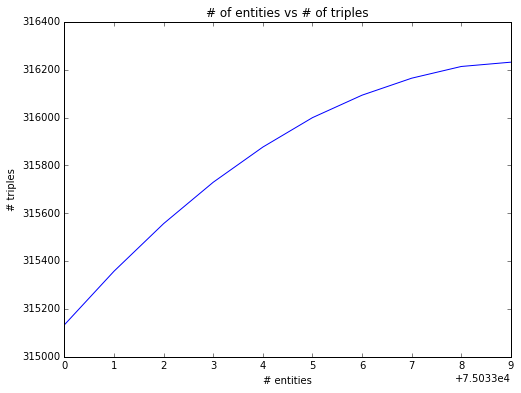

In [4]:
plt.figure(figsize=(8,6))
plt.plot(avg_cnt)
plt.title('# of entities vs # of triples')
plt.xlabel('# entities')
plt.ylabel('# triples')